# Using RePP to Predict Pass Rusher Impact as Plays Develop
*RePP: **Re**current **P**ressure **P**robabilities*

**Jon Skaza & Matt Guthrie**

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
try:
  from google.colab import drive
  in_colab = True
except:
  in_colab = False
seed = 314 # for reproducibility, used in various places
np.random.seed(seed)

## Dataset Preprocessing

In [3]:
if in_colab:
  drive.mount("/content/drive")
  path = "/content/drive/MyDrive/nfl-big-data-bowl-2023"
else:
  path = os.environ.get("BIG_DATA_BOWL")

df = pd.read_csv(f"{path}/data/dataset.csv", index_col=0)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,game_id,play_id,nfl_id,speed,pressure,x,y,dist_from_qb,qb_in_tackle_box,n_blockers,...,speed_qb,x_qb,y_qb,x_ball,y_ball,quarter,down,yards_to_go,absolute_yardline_number,score_delta
1,2021090900,97,41263,0.96,1,1.74,-5.03,7.802083,1.0,5,...,0.35,-3.92,0.34,0.00,0.00,1,3,2,43.0,0
2,2021090900,97,41263,1.08,1,1.63,-5.01,7.766557,1.0,5,...,0.54,-4.00,0.34,-0.49,0.02,1,3,2,43.0,0
3,2021090900,97,41263,1.30,1,1.47,-4.99,7.695193,1.0,5,...,0.80,-4.09,0.33,-0.85,0.03,1,3,2,43.0,0
4,2021090900,97,41263,1.48,1,1.31,-4.94,7.603138,1.0,5,...,0.99,-4.18,0.32,-1.29,0.05,1,3,2,43.0,0
5,2021090900,97,41263,2.16,1,1.04,-4.83,7.404627,1.0,5,...,1.19,-4.29,0.31,-1.77,0.06,1,3,2,43.0,0


In [14]:
# examine missingness, models will need balanced sequences
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077605 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077605 non-null  int64  
 1   play_id                   1077605 non-null  int64  
 2   nfl_id                    1077605 non-null  int64  
 3   speed                     1077605 non-null  float64
 4   pressure                  1077605 non-null  int64  
 5   x                         1077605 non-null  float64
 6   y                         1077605 non-null  float64
 7   dist_from_qb              1077605 non-null  float64
 8   qb_in_tackle_box          1077333 non-null  float64
 9   n_blockers                1077605 non-null  int64  
 10  x_C                       1077605 non-null  float64
 11  x_LT                      1077605 non-null  float64
 12  x_LG                      1077605 non-null  float64
 13  x_RG                      1

In [4]:
df.dropna(axis = 0, how = "any", inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077203 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077203 non-null  int64  
 1   play_id                   1077203 non-null  int64  
 2   nfl_id                    1077203 non-null  int64  
 3   speed                     1077203 non-null  float64
 4   pressure                  1077203 non-null  int64  
 5   x                         1077203 non-null  float64
 6   y                         1077203 non-null  float64
 7   dist_from_qb              1077203 non-null  float64
 8   qb_in_tackle_box          1077203 non-null  float64
 9   n_blockers                1077203 non-null  int64  
 10  x_C                       1077203 non-null  float64
 11  x_LT                      1077203 non-null  float64
 12  x_LG                      1077203 non-null  float64
 13  x_RG                      1

In [5]:
def make_datasets(df: pd.DataFrame, group_by: list, feats: list, outcome: str, sequences: bool, 
samples: int, test_size: float, oversample = False):

  if oversample:
    ros = RandomOverSampler(random_state = seed)
    X = df[feats + group_by].to_numpy()
    y = df[outcome].to_numpy()
    X, y = ros.fit_resample(X, y) 
    y = y.reshape(y.shape[0], 1)
    df = pd.DataFrame(np.append(X, y, axis = 1),  columns = feats + group_by + [outcome])

  if sequences or samples > 0:
    X, y  = [], []
    grouped_df = df.groupby(group_by)
    for _, group_df in grouped_df:
      f = group_df[feats].to_numpy()
      if samples > 0:
        sub_seq_lens = np.random.randint(0, len(f), samples)
        sub_seq = [f[:n] for n in sub_seq_lens]
        X += sub_seq
      else: # sequences but no sampling
        X.append(group_df[feats].to_numpy())
      if sequences:
        if samples == 0:
          y.append(group_df[[outcome]].to_numpy()[0])
        else:
          for s in range(samples):
            y.append(group_df[[outcome]].to_numpy()[0])
      else: # no sequences but multiple samples
        y.append(np.repeat(group_df[outcome].values[0], sum(sub_seq_lens)))
    if sequences:
      X = tf.keras.utils.pad_sequences(X, dtype="float", padding="pre", value = -99)
      y = np.stack(y)
    else: # no sequences but multiple samples
      X = np.concatenate(X)
      y = np.concatenate(y).ravel()

  else:
      X = df[feats].to_numpy()
      y = df[outcome].to_numpy()
    
  return train_test_split(X, y, test_size = test_size, random_state = seed) + [outcome]

In [6]:
model_metrics = {}
def add_metrics(model, outcome_name: str, model_name: str, X_test: np.ndarray, y_test: np.ndarray):
    global model_metrics
    model_metrics[outcome_name] = {}
    y_pred = model.predict(X_test)
    if type(model) == LogisticRegression:
        y_score = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = 1)
        roc = RocCurveDisplay(fpr = fpr, tpr = tpr)
        prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label= 1)
        pr = PrecisionRecallDisplay(precision=prec, recall=recall)
        auc = roc_auc_score(y_test, y_score)
        model_metrics[outcome_name][model_name] = {"auc": auc, "roc_curve": roc, "pr_curve": pr}
    else:
        evaluation = model.evaluate(X_test, y_test)
        auc = evaluation[1]
        acc = evaluation[2]
        model_metrics[outcome_name][model_name] = {"auc": auc, "acc": acc}
    print(f"Added metric for model {model_name} with outcome {outcome_name} to the model_metrics dictionary.")
    for k, v in model_metrics[outcome_name][model_name].items():
        print(f"{k}: {v}")

In [7]:
outcome = "pressure"
group_by = ["game_id", "play_id", "nfl_id"]
feats = [x for x in list(df.columns) if x not in group_by + [outcome]]

## ReSaP: **Re**current **Sa**ck **P**robabilities

### "Naive" Logistic Model

In [19]:
def model_logistic(data: list, max_iter: int):
    mod = LogisticRegression(max_iter = max_iter)
    mod.fit(data[0], data[2])
    add_metrics(mod, data[4], "logistic", data[1], data[3])
    return mod

In [ ]:
data = make_datasets(df, group_by, feats, outcome, sequences = False, samples = 0, test_size = 0.2, oversample = True)
model_logistic(data, 1000)

Added metric for model logistic with outcome pressure to the model_metrics dictionary.
auc: 0.706911237074195
roc_curve: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7feceb034df0>
pr_curve: <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x7feceb034100>


LogisticRegression(max_iter=1000)

In [152]:
data = make_datasets(df, group_by, feats, outcome, sequences = False, samples = 3, test_size = 0.2, oversample = True)
log_model = model_logistic(data, 1000)
type(log_model)

Added metric for model logistic with outcome pressure to the model_metrics dictionary.
auc: 0.7551282122789212
roc_curve: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7fece4d83610>
pr_curve: <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x7fece4c8e100>


sklearn.linear_model._logistic.LogisticRegression

### Probability Overlay animation

In [9]:
def make_probs(df, model, game_id, play_id, nfl_id):
  X, y  = [], []
  rush_df = df[(df["game_id"]==game_id) & (df["play_id"]==play_id) & (df["nfl_id"]==nfl_id)]

  f = rush_df[feats].to_numpy()
  print(len(f))
  
  if type(model) == LogisticRegression:
    X = rush_df[feats].to_numpy()
    return f, model.predict_proba(X)[:,1]
  
  else:
    sub_seq = [f[:n + 1] for n in range(len(f))]
    
    X = tf.keras.utils.pad_sequences(sub_seq, dtype="float", padding="pre", value = -99, maxlen=mod.layers[0].output_shape[1])
    return f, model.predict(X)

watt_rush , watt_probs = make_probs(df, log_model, 2021103103, 1984, 44842)
watt_probs

In [158]:
df[:1]

,game_id,play_id,nfl_id,speed,pressure,x,y,dist_from_qb,qb_in_tackle_box,n_blockers,...,speed_qb,x_qb,y_qb,x_ball,y_ball,quarter,down,yards_to_go,absolute_yardline_number,score_delta
1,2021090900,97,41263,0.96,1,1.74,-5.03,7.802083,1.0,5,...,0.35,-3.92,0.34,0.0,0.0,1,3,2,43.0,0


In [23]:
# run this once
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [130]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


plt.ioff()

# rush comparison animation 
lim_x = 10
lim_y = 10
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
ax.set_xlim(-lim_x,lim_x)
ax.set_ylim(-lim_y,lim_y)
ax.set_facecolor('#008013')
ax.tick_params(axis='y', colors='w')
xtick_loc = [-10, -5, 5, 10]
ax.set_xticks(xtick_loc)
#ax.get_yaxis().set_visible(False)
markersize=20

los, = ax.plot([],[], 'w', lw=2)
los_neg5, = ax.plot([],[], 'w', lw=1)
los_pos5, = ax.plot([],[], 'w', lw=1)



line_qb, = ax.plot([],[], 'b', lw=2)
pt_qb, = ax.plot([],[], 'pb', markersize=markersize)
line_C, = ax.plot([],[], 'b')
pt_C, = ax.plot([],[], 'ob', markersize=markersize)
line_LT, = ax.plot([],[], 'b')
pt_LT, = ax.plot([],[], 'ob', markersize=markersize)
line_LG, = ax.plot([],[], 'b')
pt_LG, = ax.plot([],[], 'ob', markersize=markersize)
line_RG, = ax.plot([],[], 'b')
pt_RG, = ax.plot([],[], 'ob', markersize=markersize)
line_RT, = ax.plot([],[], 'b')
pt_RT, = ax.plot([],[], 'ob', markersize=markersize)

line_ball, = ax.plot([],[], 'y', lw=3)
pt_ball, = ax.plot([],[], '^y', markersize=markersize)

line_rusher, = ax.plot([],[], 'r', lw=3)
pt_rusher, = ax.plot([],[], 'or', markersize=markersize)

prob_label = ax.text(0, -(lim_y - (lim_y *0.1)), "", ha='center', va='bottom', fontsize=25, bbox = (dict(facecolor='white', alpha=1)))
label = ax.text(-(lim_x - (lim_x *0.08)), lim_y - (lim_y *0.1), "", ha='left', va='top', fontsize=11, bbox = (dict(facecolor='white', alpha=1)))


max_prob_frame = np.argmax(watt_probs)


def animate(i):
    los.set_data([0, 0], [-10, 10])
    los_neg5.set_data([-5, -5], [-10, 10])
    los_pos5.set_data([5, 5], [-10, 10])

    label.set_text(f"""Game: 2021103103
Play: 1984
Player: 44842 (T.J. Watt)
Frame: {i + 1}""")
    
    prob_label.set_text(f"Pressure Probability: {int(watt_probs[i] * 100)}%")
    
    line_qb.set_xdata(-watt_rush[:i+1,17])
    line_qb.set_ydata(-watt_rush[:i+1,18])
    pt_qb.set_xdata(-watt_rush[i,17])
    pt_qb.set_ydata(-watt_rush[i,18])

    line_C.set_xdata(-watt_rush[:i+1,6])
    line_C.set_ydata(-watt_rush[:i+1,11])
    pt_C.set_xdata(-watt_rush[i,6])
    pt_C.set_ydata(-watt_rush[i,11])

    line_LT.set_xdata(-watt_rush[:i+1,7])
    line_LT.set_ydata(-watt_rush[:i+1,12])
    pt_LT.set_xdata(-watt_rush[i,7])
    pt_LT.set_ydata(-watt_rush[i,12])

    line_LG.set_xdata(-watt_rush[:i+1,8])
    line_LG.set_ydata(-watt_rush[:i+1,13])
    pt_LG.set_xdata(-watt_rush[i,8])
    pt_LG.set_ydata(-watt_rush[i,13])

    line_RG.set_xdata(-watt_rush[:i+1,9])
    line_RG.set_ydata(-watt_rush[:i+1,14])
    pt_RG.set_xdata(-watt_rush[i,9])
    pt_RG.set_ydata(-watt_rush[i,14])

    line_RT.set_xdata(-watt_rush[:i+1,10])
    line_RT.set_ydata(-watt_rush[:i+1,15])
    pt_RT.set_xdata(-watt_rush[i,10])
    pt_RT.set_ydata(-watt_rush[i,15])

    line_ball.set_xdata(-watt_rush[:i+1,19])
    line_ball.set_ydata(-watt_rush[:i+1,20])
    pt_ball.set_xdata(-watt_rush[i,19])
    pt_ball.set_ydata(-watt_rush[i,20])

    line_rusher.set_xdata(-watt_rush[:i+1,1])
    line_rusher.set_ydata(-watt_rush[:i+1,2])
    pt_rusher.set_xdata(-watt_rush[i,1])
    pt_rusher.set_ydata(-watt_rush[i,2])
         
ani = animation.FuncAnimation(fig, animate, frames=len(watt_rush))

ani.save('rush.gif',fps=10, writer = 'imagemagick')
plt.close(fig)

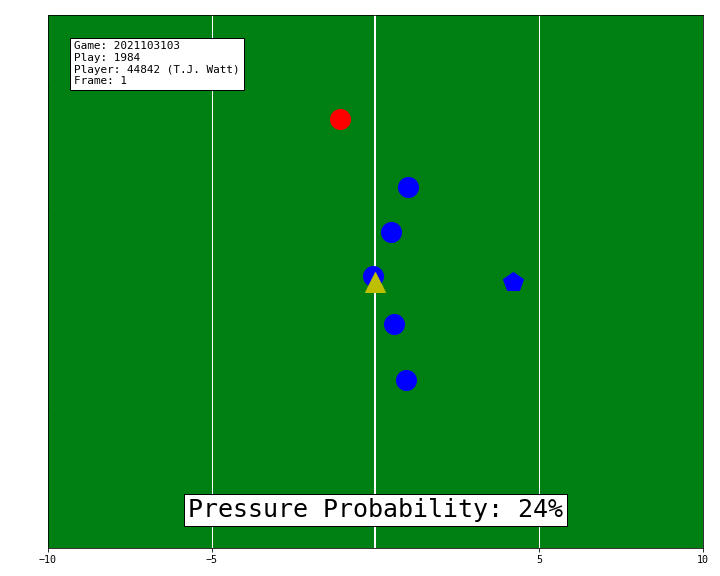

In [131]:
from IPython.display import Image
Image('rush.gif')

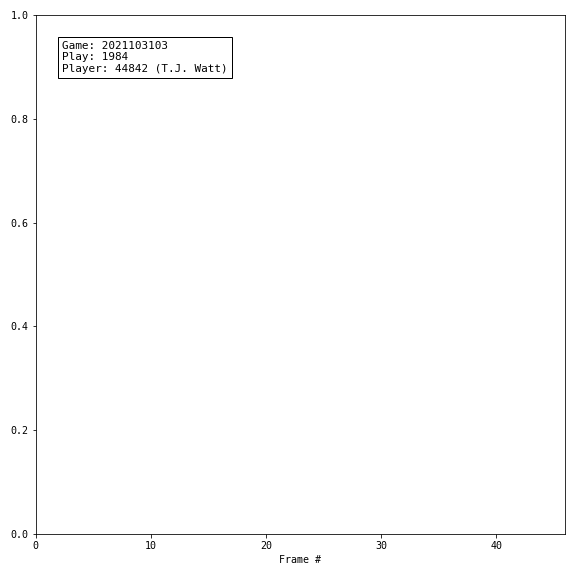

In [110]:
# pressure probability animation 
lim_x = len(watt_probs) - 1
lim_y = 1
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
ax.set_xlim(0,lim_x)
ax.set_ylim(0,lim_y)
ax.set_facecolor('w')
ax.set_xlabel('Frame #')
#ax.set_ylabel('Pressure Probability')


line_prob, = ax.plot([],[], 'black', lw=2)
label = ax.text(lim_x*0.05, 0.95, "", ha='left', va='top', fontsize=11, bbox = (dict(facecolor='white', alpha=1)))

max_prob_frame = np.argmax(watt_probs)

def animate(i):

    label.set_text(f"""Game: 2021103103
Play: 1984
Player: 44842 (T.J. Watt)""")
    
    line_prob.set_xdata(np.arange(1,i + 1))
    line_prob.set_ydata(watt_probs[:i])
         
ani = animation.FuncAnimation(fig, animate, frames=len(watt_probs))

ani.save('prob.gif',fps=10, writer = 'imagemagick')
plt.close(fig)
Image('prob.gif')

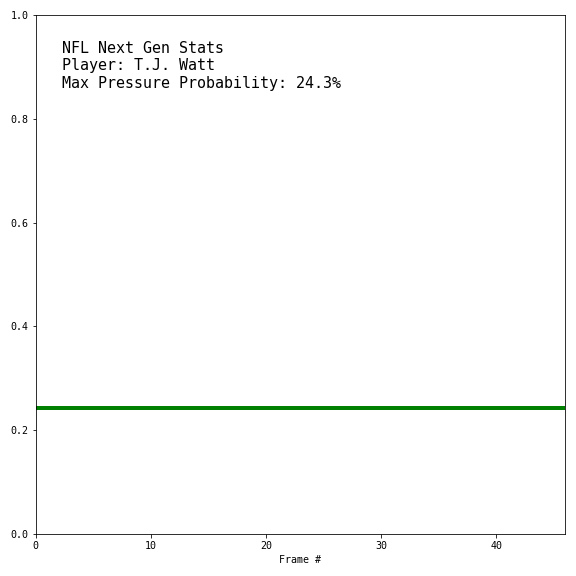

In [151]:
# pressure probability animation with max line
lim_x = len(watt_probs) - 1
lim_y = 1
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
ax.set_xlim(0,lim_x)
ax.set_ylim(0,lim_y)
ax.set_facecolor('w')
ax.set_xlabel('Frame #')
#ax.set_ylabel('Pressure Probability')


line_prob, = ax.plot([],[], 'black', lw=2)
line_max, = ax.plot([],[], 'g', lw=4)
label = ax.text(lim_x*0.05, 0.95, "", ha='left', va='top', fontsize=15)

max_prob_frame = np.argmax(watt_probs)

def animate(i):


    
    line_prob.set_xdata(np.arange(1,i + 1))
    line_prob.set_ydata(watt_probs[:i])
    line_max.set_xdata([0,lim_x])
    if i >= max_prob_frame:
      prob_text = round(max(watt_probs) * 100, 1)
      
      line_max.set_ydata([max(watt_probs),max(watt_probs)])

      if watt_probs[max_prob_frame] < 0.4:
        line_max.set_color('g')
      elif watt_probs[max_prob_frame] >= 0.4 and watt_probs[max_prob_frame] < 0.6:
        line_max.set_color('y')
      else:
        line_max.set_color('r')

    else:
      prob_text = round(watt_probs[i] * 100, 1)
      line_max.set_ydata([watt_probs[i],watt_probs[i]])

      if watt_probs[i] < 0.4:
        line_max.set_color('g')
      elif watt_probs[i] >= 0.4 and watt_probs[i] < 0.6:
        line_max.set_color('y')
      else:
        line_max.set_color('r')

    label.set_text(f"""NFL Next Gen Stats
Player: T.J. Watt
Max Pressure Probability: {prob_text}%""")
    
ani = animation.FuncAnimation(fig, animate, frames=len(watt_probs))

ani.save('prob_bar.gif',fps=10, writer = 'imagemagick')
plt.close(fig)
Image('prob_bar.gif')

### LSTM

In [10]:
def model_lstm(data: list, channels: int, num_epochs: int, val: float, folder: str):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    mod = tf.keras.Sequential()
    mod.add(tf.keras.layers.Masking(mask_value= -99., input_shape= data[0].shape[1:]))
    mod.add(tf.keras.layers.LSTM(channels, input_shape = data[0].shape[1:]))
    mod.add(tf.keras.layers.Dense(data[2].shape[1], activation="sigmoid"))

    mod.compile(loss = "binary_crossentropy", optimizer="adam",
     metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

    # callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)]

    mod.fit(data[0], data[2], epochs = num_epochs, validation_split = val)
    mod.save(folder)
    add_metrics(mod, data[4], "lstm", data[1], data[3])
    return mod

In [14]:
data = make_datasets(df.head(5000), group_by, feats, outcome, sequences = True, samples = 0, test_size = 0.2, oversample = False)
mod = model_lstm(data, 32, 1, 0.1, "full_seq")

5/5 [==============================] - 7s 432ms/step - loss: 0.8106 - auc_1: 0.2920 - binary_accuracy: 0.1128 - val_loss: 0.6750 - val_auc_1: 0.5556 - val_binary_accuracy: 0.4000


2/2 [==============================] - 0s 11ms/step - loss: 0.7001 - auc_1: 0.7361 - binary_accuracy: 0.2632
Added metric for model lstm with outcome pressure to the model_metrics dictionary.
auc: 0.7361111044883728
acc: 0.2631579041481018


In [22]:
mod.layers[0].output_shape[1]

58

In [36]:
def make_probs(df, model, game_id, play_id, nfl_id):
  X, y  = [], []
  rush_df = df[(df["game_id"]==game_id) & (df["play_id"]==play_id) & (df["nfl_id"]==nfl_id)]

  f = rush_df[feats].to_numpy()
  print(len(f))
  
  if type(model) == LogisticRegression:
    X = rush_df[feats].to_numpy()
    return f, model.predict_proba(X)[:,1]
  
  else:
    sub_seq = [f[:n + 1] for n in range(len(f))]
    
    X = tf.keras.utils.pad_sequences(sub_seq, dtype="float", padding="pre", value = -99, maxlen=mod.layers[0].output_shape[1])
    return f, model.predict(X)

watt_rush , watt_probs = make_probs(df, mod, 2021103103, 1984, 44842)
watt_probs

47
2/2 [==============================] - 0s 16ms/step


array([[0.45866653],
       [0.4603994 ],
       [0.46481836],
       [0.4682814 ],
       [0.47080794],
       [0.4717111 ],
       [0.47132295],
       [0.4696321 ],
       [0.46663177],
       [0.4629726 ],
       [0.45917588],
       [0.4553037 ],
       [0.45192352],
       [0.44849423],
       [0.4458407 ],
       [0.44314605],
       [0.44061992],
       [0.43830258],
       [0.43573946],
       [0.4338259 ],
       [0.4325087 ],
       [0.43171453],
       [0.4317755 ],
       [0.43271866],
       [0.43455645],
       [0.437065  ],
       [0.44030473],
       [0.44428965],
       [0.44869167],
       [0.4535631 ],
       [0.4584613 ],
       [0.46338457],
       [0.46821344],
       [0.47256914],
       [0.47683853],
       [0.48084643],
       [0.48499265],
       [0.48855838],
       [0.49194503],
       [0.4953793 ],
       [0.49845424],
       [0.50064474],
       [0.5031002 ],
       [0.50492454],
       [0.5060955 ],
       [0.50661486],
       [0.506607  ]], dtype=float3

In [ ]:
data = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 3, test_size = 0.2, oversample = True)
model_lstm(data, 64, 50, 0.1, "sub_seq")

In [ ]:
# train on full sequences
# test on subsequences
# X_train, _, y_train, _, _ = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 0, test_size = 0.2, oversample = True)
# _, X_test, _, y_test, _ = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 5, test_size = 0.2, oversample = True)
# data = [X_train, tf.keras.utils.pad_sequences(X_test, dtype="float", padding="pre", value = -99, maxlen = 193), X_test, y_train, y_test, "sensitivity"]
# model_lstm(data, 128, 50, 0.1)

### Transformer

In [ ]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
#     x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

In [ ]:
# def build_model(
#     input_shape,
#     head_size,
#     num_heads,
#     ff_dim,
#     num_transformer_blocks,
#     mlp_units,
#     lstm_units,
#     dropout=0,
#     mlp_dropout=0,
# ):
#     inputs = tf.keras.Input(shape=input_shape)
#     x = inputs
#     x = tf.keras.layers.Masking(mask_value=-99.,input_shape= input_shape)(x)
#     x = tf.keras.layers.LSTM(lstm_units, input_shape = input_shape, return_sequences=True)(x)

#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
    
#     for dim in mlp_units:
#         x = tf.keras.layers.Dense(dim, activation="relu")(x)
#         x = tf.keras.layers.Dropout(mlp_dropout)(x)
    
#     outputs = tf.keras.layers.Dense(y.shape[1], activation="sigmoid")(x)
#     return tf.keras.Model(inputs, outputs)

In [ ]:
# outcomes = ["pff_sack", "havoc"]
# datasets = {}
# for o in outcomes:
#     group_by = ["game_id", "play_id", "nfl_id"]
#     outcome = [o]
#     feats = [x for x in list(df.columns) if x not in group_by + outcomes]

#     X, y = make_features(df, group_by, feats, outcome)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

#     weight_0 = (1 / sum(y_train == [0])) * (len(y_train) / 2.0)
#     weight_1 = (1 / sum(y_train == [1])) * (len(y_train) / 2.0)
#     class_weight = {0: weight_0, 1: weight_1}

#     num_epochs = 1
#     val = 0.2 

#     datasets[o] = {"X_train": X_train, "X_test": X_test,
#     "y_train": y_train, "y_test": y_test, "class_weight": class_weight,
#     "num_epochs": num_epochs, "val": val}

In [ ]:
# for k, v in datasets.items():
#     input_shape = v["X_train"].shape[1:]

#     model = build_model(
#         input_shape,
#         head_size=128,
#         num_heads=4,
#         ff_dim=4,
#         num_transformer_blocks=1,
#         mlp_units=[128],
#         mlp_dropout=0.2,
#         dropout=0.25,
#         lstm_units=32
#     )

#     model.compile(
#         loss="binary_crossentropy",
#         optimizer="adam",
#         #optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         metrics = [tf.keras.metrics.AUC()]
#     )
#     #model.summary()

#     callbacks = [tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3, restore_best_weights=True)]

#     model.fit(
#         v["X_train"],
#         v["y_train"],
#         validation_split=v["val"],
#         epochs=v["num_epochs"],
#         #batch_size=64,
#         callbacks=callbacks,
#         class_weight = v["class_weight"]
#     )

#     model.evaluate(v["X_test"], v["y_test"], verbose=1)